<a href="https://colab.research.google.com/github/Raghav847/pytorch_learn/blob/main/notebooks/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. classification data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"first 5 samples of X:\n {X[:5]}")
print(f"first 5 samples of y:\n {y[:5]}")

first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y:
 [1 1 1 1 0]


In [5]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


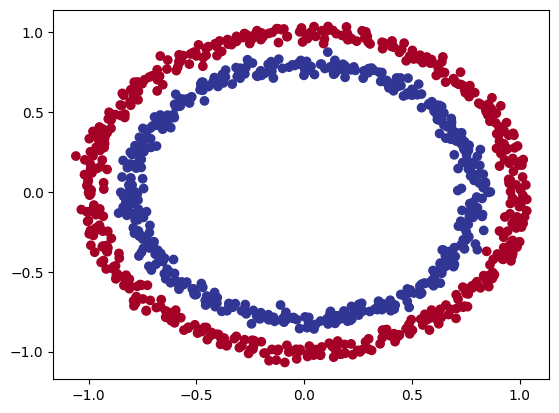

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and Output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f"one sample for X: {X_sample} and y: {y_sample}")
print(f"Shapes of sample of X: {X_sample.shape} and y: {y_sample.shape}")

one sample for X: [0.75424625 0.23148074] and y: 1
Shapes of sample of X: (2,) and y: ()


### 1.2 data into tensors and train and test splits

In [9]:
import torch
torch.__version__

'2.8.0+cu126'

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [12]:
#train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

In [14]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #2 -> 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #5 -> 1

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> out


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
device

'cuda'

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4895,  0.5052],
                      [ 0.2363,  0.4329],
                      [ 0.1322,  0.1546],
                      [-0.2613, -0.5311],
                      [-0.4457, -0.5777]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4856, -0.6481, -0.3734,  0.0259, -0.4668], device='cuda:0')),
             ('1.weight',
              tensor([[0.4466, 0.0194, 0.3132, 0.2150, 0.3022]], device='cuda:0')),
             ('1.bias', tensor([-0.1539], device='cuda:0'))])

In [20]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds.shape)}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 preds:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 2
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 preds:
tensor([[-0.2341],
        [-0.2070],
        [-0.2519],
        [-0.2292],
        [-0.1677],
        [-0.1518],
        [-0.1424],
        [-0.1293],
        [-0.2554],
        [-0.2043]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


###2.1 loss function and optimizer

In [21]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [22]:
#accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train

### 3.1 raw logits -> prediction probabilities -> prediction labels

In [23]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2341],
        [-0.2070],
        [-0.2519],
        [-0.2292],
        [-0.1677]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4418],
        [0.4484],
        [0.4374],
        [0.4429],
        [0.4582]], device='cuda:0')

In [26]:
y_preds = torch.round(y_pred_probs)

# logits -> pred probs -> pred labels
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

##Training Loop

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#train/test loop
for epoch in range(epochs):
  ##Training
  model_0.train()

  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> pred_probs -> pred_labels

  #loss/accuracy
  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #Optimizer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #Optimizer step
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%, | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69839, Acc: 50.00%, | Test loss: 0.69859, Test acc: 50.00%
Epoch: 10 | Loss: 0.69474, Acc: 50.00%, | Test loss: 0.69568, Test acc: 50.00%
Epoch: 20 | Loss: 0.69369, Acc: 46.25%, | Test loss: 0.69492, Test acc: 42.50%
Epoch: 30 | Loss: 0.69338, Acc: 48.50%, | Test loss: 0.69473, Test acc: 49.50%
Epoch: 40 | Loss: 0.69327, Acc: 49.12%, | Test loss: 0.69468, Test acc: 50.00%
Epoch: 50 | Loss: 0.69322, Acc: 49.50%, | Test loss: 0.69466, Test acc: 50.50%
Epoch: 60 | Loss: 0.69319, Acc: 49.88%, | Test loss: 0.69465, Test acc: 49.50%
Epoch: 70 | Loss: 0.69317, Acc: 50.00%, | Test loss: 0.69464, Test acc: 50.00%
Epoch: 80 | Loss: 0.69316, Acc: 50.12%, | Test loss: 0.69462, Test acc: 49.50%
Epoch: 90 | Loss: 0.69314, Acc: 50.12%, | Test loss: 0.69461, Test acc: 49.00%


## 4. Predictions and evaluation

In [28]:
import requests
from pathlib import Path

#helper functions from github
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Download helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_function.py


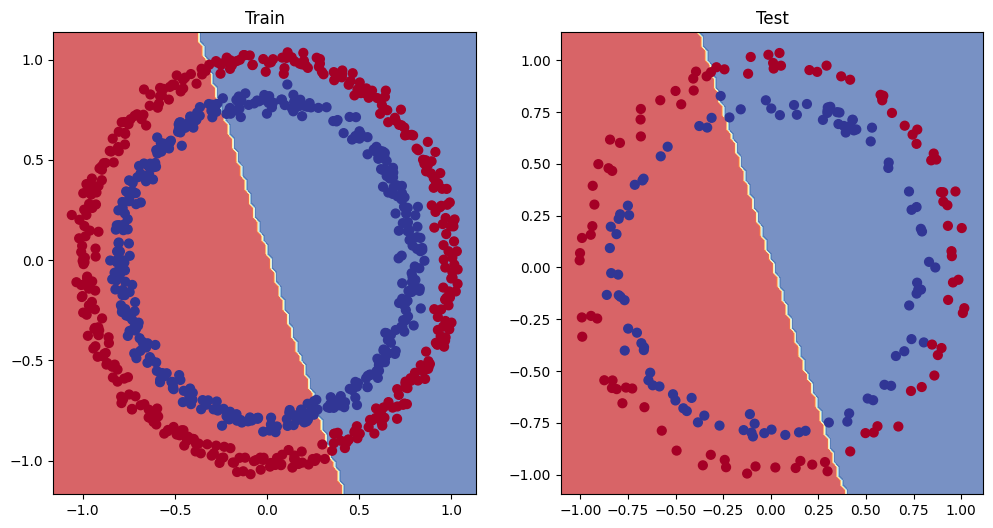

In [29]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improve the model

In [30]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


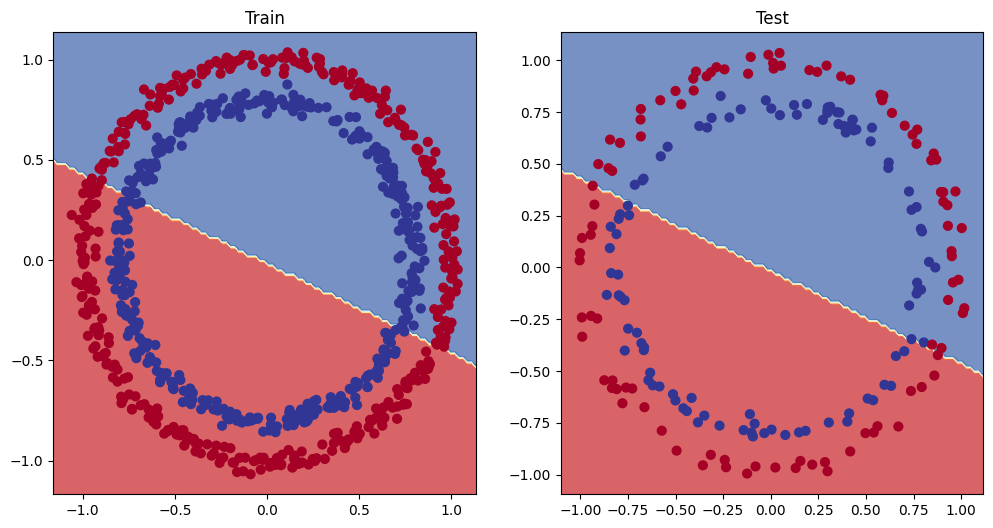

In [34]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)